# 椭圆轨道

In [3]:
import torch
import torchvision
import numpy as np
import importlib
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams
from gaussian_renderer import render
from scene import Scene, GaussianModel
import tqdm as notebook_tqdm

In [25]:
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--save_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(["-s", "data/kitchen_8", "-m", "output/kitchen_8"])
dataset = lp.extract(args)
opt = op.extract(args)
pipe = pp.extract(args)

In [26]:
gaussians = GaussianModel(dataset.sh_degree, opt.optimizer_type)
scene = Scene(dataset, gaussians)

Reading camera 8/8
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  22


In [27]:
views = scene.getTrainCameras()

In [28]:
poses = []
for view in views:
    pose = np.eye(4)
    pose[:3] = np.concatenate([view.R.T, view.T[:, None]], 1)
    pose = np.linalg.inv(pose)
    pose[:, 1:3] *= -1
    poses.append(pose)

# 伪视图生成

In [1]:
import torch
import torchvision
import numpy as np
import importlib
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams
from gaussian_renderer import render
from scene import Scene, GaussianModel
import tqdm as notebook_tqdm

In [2]:
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument('--ip', type=str, default="127.0.0.1")
parser.add_argument('--port', type=int, default=6009)
parser.add_argument('--debug_from', type=int, default=-1)
parser.add_argument('--detect_anomaly', action='store_true', default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--save_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--start_checkpoint", type=str, default = None)
args = parser.parse_args(["-s", "data/bicycle_2", "-m", "output3/bicycle_2"])
dataset = lp.extract(args)
opt = op.extract(args)
pipe = pp.extract(args)

In [51]:
gaussians = GaussianModel(dataset.sh_degree, opt.optimizer_type)
scene = Scene(dataset, gaussians)

Reading camera 2/2
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  170618


In [52]:
ori_views = scene.getTrainCameras()

In [20]:
from scipy.spatial.transform import Rotation as R
R1 = R.from_quat(np.array([0.8395176994653495, -0.00012065300298831745, 0.5433144542162123, -0.004406990696602375])).as_matrix()  # (3,3)
R2 = R.from_quat(np.array([0.0, 0.0, 0.0, 1])).as_matrix()  # (3,3)

In [53]:
ori_views[0].R

array([[ 0.40957996, -0.0075306 , -0.91224314],
       [ 0.00726839,  0.99996113, -0.00499134],
       [ 0.91224526, -0.00458618,  0.40961878]])

In [93]:
def get_new_pose(original_pose, num_views=14):
    R1 = original_pose[0].R # (3,3)
    R2 = original_pose[1].R  # (3,3)
    t1 =  original_pose[0].T
    t2 =  original_pose[1].T
    C1 = -R1.T @ t1  # (3,1)
    C2 = -R2.T @ t2  # (3,1)
    center = (C1 + C2) / 2  # 椭圆中心 (3,1)
    a = np.linalg.norm(C1 - C2) / 2  # 长轴
    b = a / 2  # 短轴

    # 计算两个相机视角之间的角度范围
    angle1 = np.arctan2(C1[1] - center[1], C1[0] - center[0])  # 视角1的角度
    angle2 = np.arctan2(C2[1] - center[1], C2[0] - center[0])  # 视角2的角度

    # 确保角度按顺时针或逆时针顺序排列
    if angle2 < angle1:
        angle2 += 2 * np.pi  # 保证 angle2 大于 angle1

    # 在两个视角之间均匀分布的角度
    angles = np.linspace(angle1, angle2, num_views)  # 均匀采样角度

    # 生成椭圆轨道上的点
    ellipse_points = np.hstack([a * np.cos(angles).reshape(-1, 1),
                                b * np.sin(angles).reshape(-1, 1),
                                np.zeros((num_views, 1))])  # (num_views, 3)

    # 处理广播问题 (转换 center 为 (1,3) 以进行广播)
    center = center.reshape(1, 3)  # 确保形状匹配
    ellipse_points = ellipse_points + center  # (num_views, 3) + (1, 3) 可广播

    # 计算每个点的位姿
    poses = []
    for point in ellipse_points:
        # 相机位置
        C_new = point.reshape(3, 1)  # 转换为 (3,1)

        # 相机朝向场景中心
        look_at = center.T  # 变成 (3,1)
        forward = look_at - C_new
        forward = forward / np.linalg.norm(forward)

        # 计算旋转矩阵
        up = np.array([0, 1, 0])  # 假设上方向为 Y 轴
        right = np.cross(up, forward.squeeze())  # 计算右方向
        right = right / np.linalg.norm(right)
        up = np.cross(forward.squeeze(), right)  # 重新计算 up

        R_new = np.vstack((right, up, -forward.squeeze())).T  # 计算新的旋转矩阵
        # 强制保证旋转矩阵是右手坐标系
        if np.linalg.det(R_new) < 0:
            R_new = -R_new

        # 计算新的平移向量
        t_new = -R_new @ C_new

        # 将旋转矩阵和平移向量合并为一个 (3, 4) 的矩阵
        pose_new = np.hstack([R_new, t_new])  # (3, 4)

        # 添加新位姿到 poses 列表中
        poses.append(pose_new)

    # 将第一个和最后一个视角添加为原始位姿
    # R1_t = np.hstack([R1, t1])  # (3, 4)
    # R2_t = np.hstack([R2, t2])  # (3, 4)

    # poses.insert(0, R1_t)  # 在最前面添加原始第一个相机位姿
    # poses.append(R2_t)  # 在最后添加原始第二个相机位姿

    poses_np = np.array(poses, dtype=np.float32)  
    return poses_np

In [94]:
render_poses = get_new_pose(ori_views)

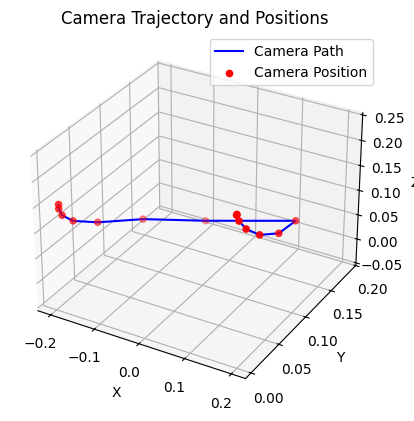

In [97]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 提取相机的轨迹（即平移向量 t_new）
trajectories = render_poses[:, :, 3]  # 取每个位姿的平移向量 (t_new)

# 提取 X, Y, Z 坐标
X = trajectories[:, 0]
Y = trajectories[:, 1]
Z = trajectories[:, 2]

# 绘制相机轨迹
ax.plot(X, Y, Z, label='Camera Path', color='blue')

# 绘制相机位置
ax.scatter(X, Y, Z, color='red', label='Camera Position')

# 添加标签
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# 设置图形标题
ax.set_title('Camera Trajectory and Positions')

# 显示图例
ax.legend()

# 显示图形
plt.show()

In [106]:
import os, glob
def get_filelist(data_dir, postfixes):
    patterns = [os.path.join(data_dir, f"*.{postfix}") for postfix in postfixes]
    file_list = []
    for pattern in patterns:
        file_list.extend(glob.glob(pattern))
    file_list.sort()
    return file_list

In [107]:
print(get_filelist("data1/bicycle",["JPG", "png"]))

['data1/bicycle\\bicycle_01.JPG', 'data1/bicycle\\bicycle_02.png', 'data1/bicycle\\bicycle_03.png', 'data1/bicycle\\bicycle_04.png', 'data1/bicycle\\bicycle_06.png', 'data1/bicycle\\bicycle_07.JPG']
